 Model klasörü oluşturuldu: Saved_Advanced_Models
 İşlem Cihazı: cpu

 BÖLÜM 1: VERİ YÜKLENİYOR VE TEMİZLENİYOR...
 Veri Hazır. Toplam Kayıt: 2218631

 BÖLÜM 3: ML İÇİN VERİ HAZIRLIĞI
 ML Verisi Hazır: 40000 eğitim örneği.

 BÖLÜM 4: MODELLER EĞİTİLİYOR
    -> Baseline Accuracy: %75.52
      LR Accuracy: %52.11, AUC: 0.533
      Linear SVC Accuracy: %52.13, AUC: 0.534
    -> Gaussian Naive Bayes Eğitiliyor...
      Gaussian NB Accuracy: %75.40
    -> LightGBM Eğitiliyor...
      LGBM Accuracy: %77.14, AUC: 0.676
    -> Extra Trees Eğitiliyor...
      Extra Trees Accuracy: %71.58

 BÖLÜM 5: DERİN ÖĞRENME MODELLERİ EĞİTİLİYOR
    -> LSTM Eğitiliyor...
    -> Deep MLP Eğitiliyor...


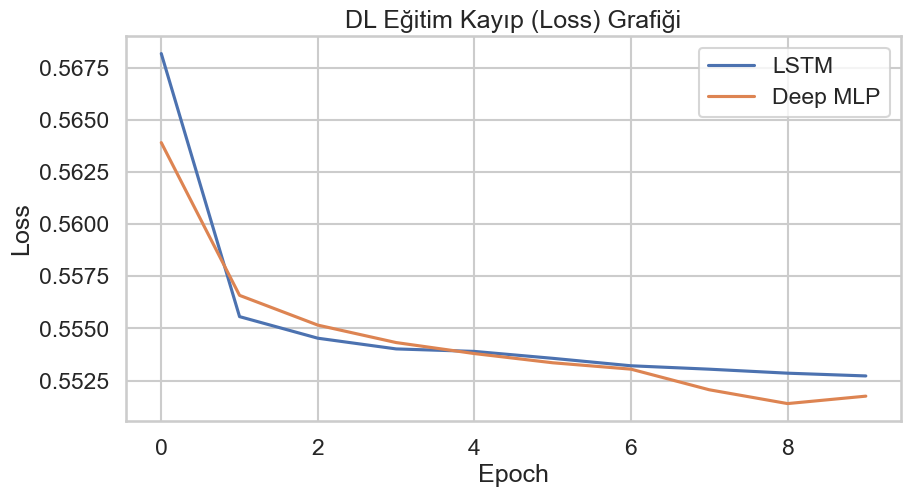


 PROJE SONUÇLARI
                 Model  Accuracy    Recall  Precision        F1       AUC
6             LightGBM    0.7714  0.094363   0.770000  0.168122  0.675986
3                  KNN    0.7246  0.202206   0.381944  0.264423  0.594661
2        Decision Tree    0.7382  0.171977   0.416008  0.243353  0.594659
7          Extra Trees    0.7158  0.209150   0.361072  0.264873  0.593925
9        Deep MLP (DL)    0.7571  0.011029   0.771429  0.021748  0.585935
8            LSTM (DL)    0.7554  0.002451   0.600000  0.004882  0.567149
5          Gaussian NB    0.7540  0.002859   0.269231  0.005659  0.556438
4           Linear SVC    0.5213  0.514297   0.259214  0.344695  0.533654
1  Logistic Regression    0.5211  0.514706   0.259206  0.344780  0.533361
0  Baseline (Referans)    0.7552  0.000000   0.000000  0.000000  0.500000


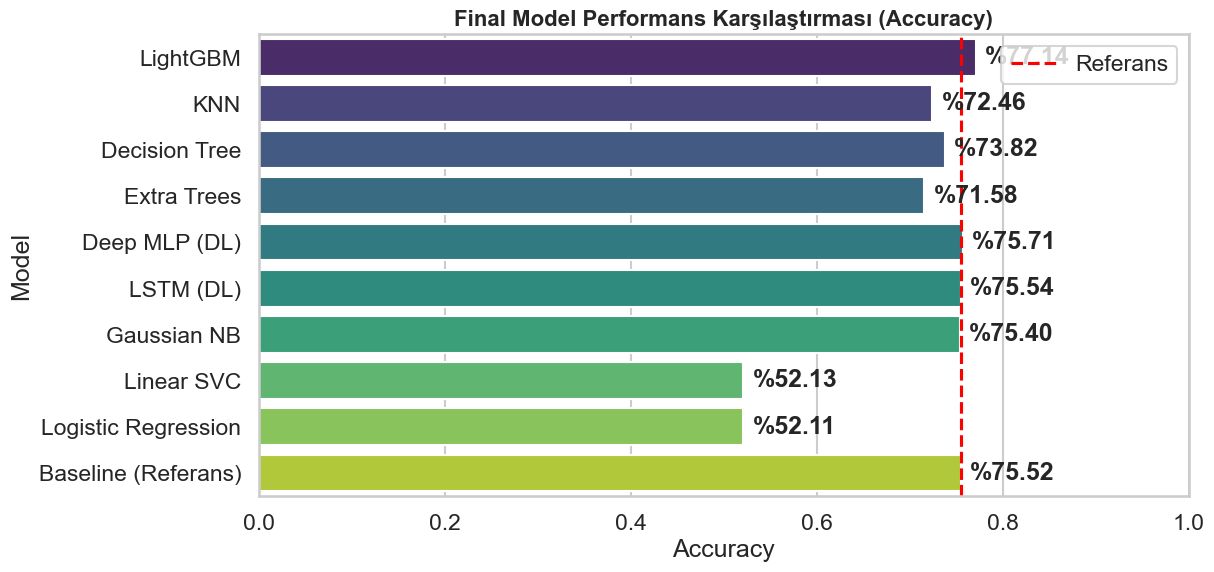

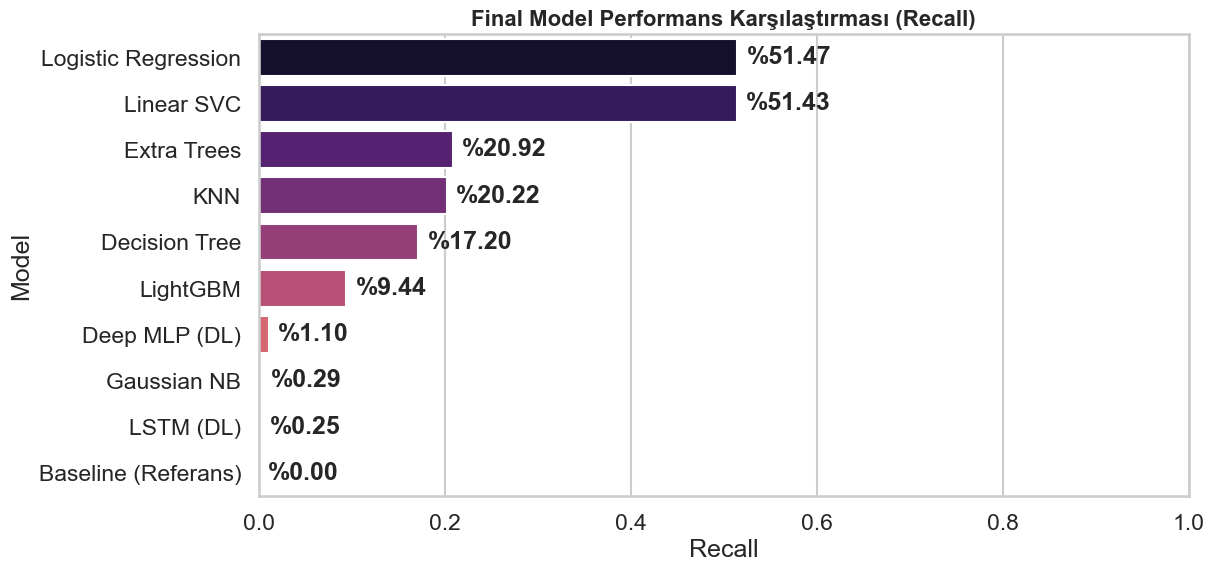

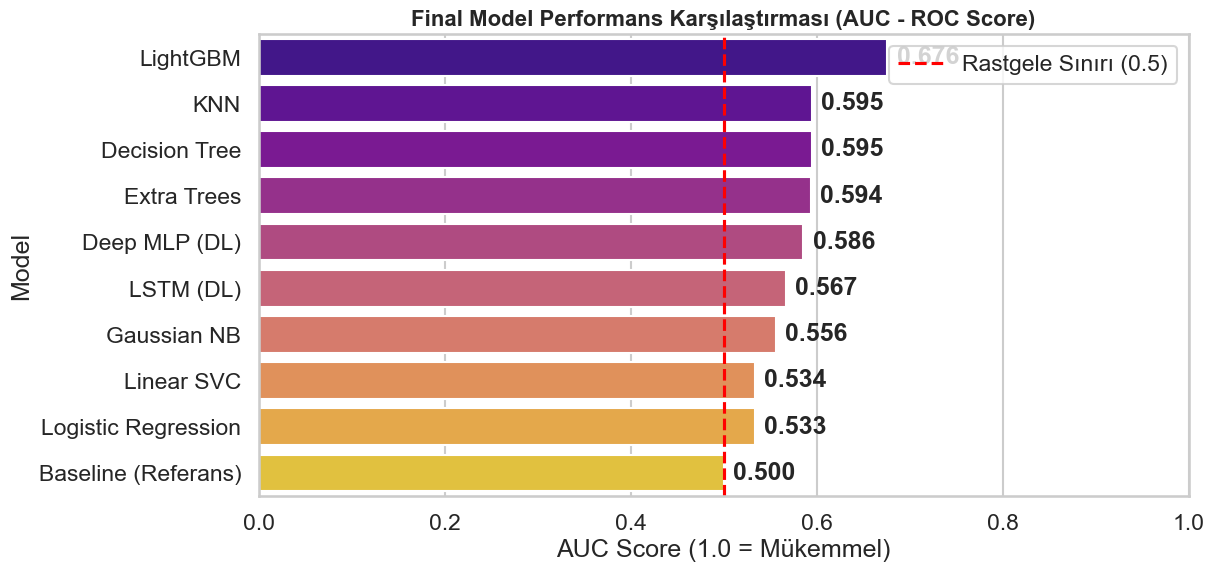

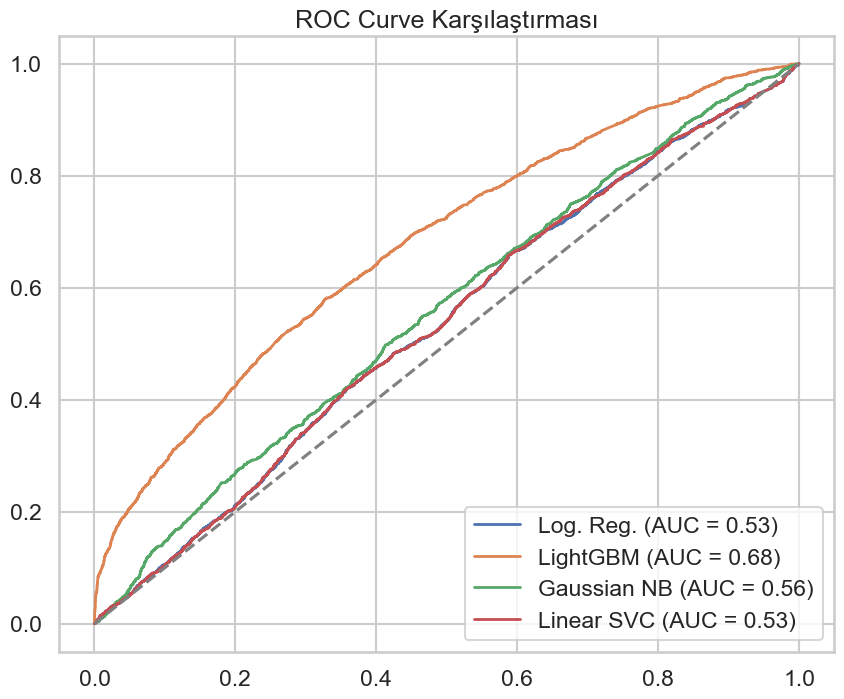


 TÜM İŞLEMLER BAŞARIYLA TAMAMLANDI!
 Modeller: Saved_Advanced_Models


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import time
import warnings
import shutil

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
# roc_auc_score metriği eklendi
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.dummy import DummyClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB

try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError:
    LGBM_AVAILABLE = False
    print(" LightGBM yüklü değil, bu model atlanacak.")

try:
    import torch
    import torch.nn as nn
    import torch.optim as optim
    from torch.utils.data import DataLoader, TensorDataset
    TORCH_AVAILABLE = True
except ImportError:
    TORCH_AVAILABLE = False
    print(" PyTorch yüklü değil, DL modelleri atlanacak.")

warnings.filterwarnings('ignore')
sns.set_theme(style="whitegrid", context="talk")
plt.rcParams['figure.figsize'] = (14, 8)


DATA_PATH = 'Default_Data.csv' 
MODEL_SAVE_DIR = "Saved_Advanced_Models"

# Klasör Temizliği
if os.path.exists(MODEL_SAVE_DIR):
    try:
        shutil.rmtree(MODEL_SAVE_DIR)
        print(f"  Eski model klasörü silindi: {MODEL_SAVE_DIR}")
    except Exception as e:
        print(f" Silinemedi {MODEL_SAVE_DIR}: {e}")
os.makedirs(MODEL_SAVE_DIR)
print(f" Model klasörü oluşturuldu: {MODEL_SAVE_DIR}")

device = torch.device("cuda" if TORCH_AVAILABLE and torch.cuda.is_available() else "cpu")
print(f" İşlem Cihazı: {device}")

# ==========================================
# BÖLÜM 1: VERİ YÜKLENİYOR VE TEMİZLENİYOR
# ==========================================

print("\n" + "="*50)
print(" BÖLÜM 1: VERİ YÜKLENİYOR VE TEMİZLENİYOR...")
print("="*50)

try:
    df = pd.read_csv(DATA_PATH, low_memory=False)
except FileNotFoundError:
    print(f" Hata: {DATA_PATH} bulunamadı. Lütfen dosya yolunu kontrol et.")
    # Kodun çökmemesi için sahte veri ile devam etme (Test Amaçlı)
    # Gerçek kullanımda burayı 'exit()' yapabilirsiniz.
    exit()

df.columns = [col.upper().replace(' ', '_') for col in df.columns]

df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'], errors='coerce')
# Saat formatını düzeltme
df['CRASH_TIME'] = df['CRASH_TIME'].astype(str).apply(lambda x: x.split(' ')[-1] if ' ' in x else x)
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'], format='%H:%M', errors='coerce').dt.time

num_cols = [
    'NUMBER_OF_PERSONS_INJURED', 'NUMBER_OF_PERSONS_KILLED',
    'NUMBER_OF_PEDESTRIANS_INJURED', 'NUMBER_OF_MOTORIST_INJURED',
    'NUMBER_OF_CYCLIST_INJURED'
]
for col in num_cols:
    if col in df.columns:
        df[col].fillna(0, inplace=True)


df['HOUR'] = pd.to_datetime(df['CRASH_TIME'].astype(str), format='%H:%M:%S', errors='coerce').dt.hour
df['DAY_OF_WEEK'] = df['CRASH_DATE'].dt.day_name()
df['YEAR_MONTH'] = df['CRASH_DATE'].dt.to_period('M')

# Severity
def classify_severity(row):
    if row['NUMBER_OF_PERSONS_KILLED'] > 0:
        return 'Ölümcül (Fatal)'
    elif row['NUMBER_OF_PERSONS_INJURED'] > 0:
        return 'Yaralanmalı (Injury)'
    else:
        return 'Maddi Hasarlı (No Injury)'

df['SEVERITY_TYPE'] = df.apply(classify_severity, axis=1)

df['SEVERITY_BINARY'] = ((df['NUMBER_OF_PERSONS_INJURED'] > 0) | (df['NUMBER_OF_PERSONS_KILLED'] > 0)).astype(int)

print(f" Veri Hazır. Toplam Kayıt: {df.shape[0]}")

# ==========================================
# BÖLÜM 2: ML İÇİN VERİ HAZIRLIĞI
# ==========================================

print("\n" + "="*50)
print(" BÖLÜM 3: ML İÇİN VERİ HAZIRLIĞI")
print("="*50)

df_ml = df.sample(n=min(50000, len(df)), random_state=42).copy()

# Özellik Seçimi
features = ['BOROUGH', 'VEHICLE_TYPE_CODE_1', 'CONTRIBUTING_FACTOR_VEHICLE_1']
for col in features:
    df_ml[col] = df_ml[col].astype(str).fillna('UNKNOWN')

# Encoding
le_dict = {}
for col in features:
    le = LabelEncoder()
    df_ml[col] = le.fit_transform(df_ml[col])
    le_dict[col] = le
    joblib.dump(le, os.path.join(MODEL_SAVE_DIR, f'le_{col}.pkl'))

# Koordinatlar
if 'LATITUDE' in df_ml.columns:
    df_ml['LATITUDE'] = df_ml['LATITUDE'].fillna(df_ml['LATITUDE'].median())
    features.append('LATITUDE')
if 'LONGITUDE' in df_ml.columns:
    df_ml['LONGITUDE'] = df_ml['LONGITUDE'].fillna(df_ml['LONGITUDE'].median())
    features.append('LONGITUDE')

X = df_ml[features].values
y = df_ml['SEVERITY_BINARY'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(MODEL_SAVE_DIR, 'scaler.pkl'))

print(f" ML Verisi Hazır: {X_train.shape[0]} eğitim örneği.")


# ==========================================
# BÖLÜM 3: MODELLER EĞİTİLİYOR (AUC EKLENDİ)
# ==========================================

print("\n" + "="*50)
print(" BÖLÜM 4: MODELLER EĞİTİLİYOR")
print("="*50)

results = []

# 1. REFERANS MODEL (Baseline)
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)
y_pred_dummy = dummy.predict(X_test)
# Dummy için AUC 0.5 kabul edilir
try:
    y_prob_dummy = dummy.predict_proba(X_test)[:, 1]
    auc_dummy = roc_auc_score(y_test, y_prob_dummy)
except:
    auc_dummy = 0.5

results.append({
    'Model': 'Baseline (Referans)', 
    'Accuracy': accuracy_score(y_test, y_pred_dummy), 
    'Recall': 0, 
    'Precision': 0, 
    'F1': 0,
    'AUC': auc_dummy # AUC Eklendi
})
print(f"    -> Baseline Accuracy: %{results[-1]['Accuracy']*100:.2f}")

# 2. Logistic Regression
lr_model = LogisticRegression(class_weight='balanced', max_iter=1000, n_jobs=-1)
lr_model.fit(X_train_scaled, y_train)
y_pred_lr = lr_model.predict(X_test_scaled)
y_prob_lr = lr_model.predict_proba(X_test_scaled)[:, 1] # Olasılık hesapla

results.append({
    'Model': 'Logistic Regression',
    'Accuracy': accuracy_score(y_test, y_pred_lr),
    'Recall': recall_score(y_test, y_pred_lr),
    'Precision': precision_score(y_test, y_pred_lr),
    'F1': f1_score(y_test, y_pred_lr),
    'AUC': roc_auc_score(y_test, y_prob_lr) # AUC Eklendi
})
print(f"      LR Accuracy: %{results[-1]['Accuracy']*100:.2f}, AUC: {results[-1]['AUC']:.3f}")
joblib.dump(lr_model, os.path.join(MODEL_SAVE_DIR, 'lr_model.pkl'))

# 3. Decision Tree
dt_model = DecisionTreeClassifier(max_depth=15, random_state=42)
dt_model.fit(X_train_scaled, y_train)
y_pred_dt = dt_model.predict(X_test_scaled)
y_prob_dt = dt_model.predict_proba(X_test_scaled)[:, 1]

results.append({
    'Model': 'Decision Tree',
    'Accuracy': accuracy_score(y_test, y_pred_dt),
    'Recall': recall_score(y_test, y_pred_dt),
    'Precision': precision_score(y_test, y_pred_dt),
    'F1': f1_score(y_test, y_pred_dt),
    'AUC': roc_auc_score(y_test, y_prob_dt) # AUC Eklendi
})
joblib.dump(dt_model, os.path.join(MODEL_SAVE_DIR, 'dt_model.pkl'))

# 4. KNN
knn_model = KNeighborsClassifier(n_neighbors=5, n_jobs=-1)
knn_model.fit(X_train_scaled, y_train)
y_pred_knn = knn_model.predict(X_test_scaled)
try:
    y_prob_knn = knn_model.predict_proba(X_test_scaled)[:, 1]
    auc_knn = roc_auc_score(y_test, y_prob_knn)
except:
    auc_knn = 0.5

results.append({
    'Model': 'KNN',
    'Accuracy': accuracy_score(y_test, y_pred_knn),
    'Recall': recall_score(y_test, y_pred_knn),
    'Precision': precision_score(y_test, y_pred_knn),
    'F1': f1_score(y_test, y_pred_knn),
    'AUC': auc_knn
})
joblib.dump(knn_model, os.path.join(MODEL_SAVE_DIR, 'knn_model.pkl'))

# 5. Linear SVC
# SVC için probability=True yapmazsak predict_proba gelmez, LinearSVC'de decision_function kullanılır
svc_model = LinearSVC(class_weight='balanced', dual=False, random_state=42)
svc_model.fit(X_train_scaled, y_train)
y_pred_svc = svc_model.predict(X_test_scaled)
y_score_svc = svc_model.decision_function(X_test_scaled) # AUC için skor

results.append({
    'Model': 'Linear SVC',
    'Accuracy': accuracy_score(y_test, y_pred_svc),
    'Recall': recall_score(y_test, y_pred_svc),
    'Precision': precision_score(y_test, y_pred_svc),
    'F1': f1_score(y_test, y_pred_svc),
    'AUC': roc_auc_score(y_test, y_score_svc) # AUC Eklendi
})
print(f"      Linear SVC Accuracy: %{results[-1]['Accuracy']*100:.2f}, AUC: {results[-1]['AUC']:.3f}")
joblib.dump(svc_model, os.path.join(MODEL_SAVE_DIR, 'svc_model.pkl'))

# --- GaussianNB ---
print("    -> Gaussian Naive Bayes Eğitiliyor...")
gnb_model = GaussianNB()
gnb_model.fit(X_train_scaled, y_train)
y_pred_gnb = gnb_model.predict(X_test_scaled)
y_prob_gnb = gnb_model.predict_proba(X_test_scaled)[:, 1]

results.append({
    'Model': 'Gaussian NB',
    'Accuracy': accuracy_score(y_test, y_pred_gnb),
    'Recall': recall_score(y_test, y_pred_gnb),
    'Precision': precision_score(y_test, y_pred_gnb),
    'F1': f1_score(y_test, y_pred_gnb),
    'AUC': roc_auc_score(y_test, y_prob_gnb)
})
print(f"      Gaussian NB Accuracy: %{results[-1]['Accuracy']*100:.2f}")
joblib.dump(gnb_model, os.path.join(MODEL_SAVE_DIR, 'gnb_model.pkl'))


# 6. LightGBM
if LGBM_AVAILABLE:
    print("    -> LightGBM Eğitiliyor...")
    lgb_model = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.05, random_state=42, verbose=-1)
    lgb_model.fit(X_train_scaled, y_train)
    y_pred_lgb = lgb_model.predict(X_test_scaled)
    y_prob_lgb = lgb_model.predict_proba(X_test_scaled)[:, 1]

    results.append({
        'Model': 'LightGBM',
        'Accuracy': accuracy_score(y_test, y_pred_lgb),
        'Recall': recall_score(y_test, y_pred_lgb),
        'Precision': precision_score(y_test, y_pred_lgb),
        'F1': f1_score(y_test, y_pred_lgb),
        'AUC': roc_auc_score(y_test, y_prob_lgb) # AUC Eklendi
    })
    print(f"      LGBM Accuracy: %{results[-1]['Accuracy']*100:.2f}, AUC: {results[-1]['AUC']:.3f}")
    joblib.dump(lgb_model, os.path.join(MODEL_SAVE_DIR, 'lgb_model.pkl'))
    

# 7. Extra Trees
print("    -> Extra Trees Eğitiliyor...")
et_model = ExtraTreesClassifier(n_estimators=100, random_state=42, n_jobs=-1)
et_model.fit(X_train_scaled, y_train)
y_pred_et = et_model.predict(X_test_scaled)
y_prob_et = et_model.predict_proba(X_test_scaled)[:, 1]

results.append({
    'Model': 'Extra Trees',
    'Accuracy': accuracy_score(y_test, y_pred_et),
    'Recall': recall_score(y_test, y_pred_et),
    'Precision': precision_score(y_test, y_pred_et),
    'F1': f1_score(y_test, y_pred_et),
    'AUC': roc_auc_score(y_test, y_prob_et)
})
print(f"      Extra Trees Accuracy: %{results[-1]['Accuracy']*100:.2f}")
joblib.dump(et_model, os.path.join(MODEL_SAVE_DIR, 'et_model.pkl'))


# ==========================================
# BÖLÜM 4: DERİN ÖĞRENME (DL ve PyTorch)
# ==========================================

if TORCH_AVAILABLE:
    print("\n" + "="*50)
    print(" BÖLÜM 5: DERİN ÖĞRENME MODELLERİ EĞİTİLİYOR")
    print("="*50)

    # Tensor Hazırlığı
    X_train_t = torch.FloatTensor(X_train_scaled).to(device)
    y_train_t = torch.FloatTensor(y_train).unsqueeze(1).to(device)
    X_test_t = torch.FloatTensor(X_test_scaled).to(device)
    y_test_t = torch.FloatTensor(y_test).unsqueeze(1).to(device)

    train_ds = TensorDataset(X_train_t, y_train_t)
    train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)

    # Modeller
    class LSTMModel(nn.Module):
        def __init__(self, input_size, hidden_size=64):
            super(LSTMModel, self).__init__()
            self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
            self.fc = nn.Linear(hidden_size, 1)
            self.sigmoid = nn.Sigmoid()
        def forward(self, x):
            x = x.unsqueeze(1) 
            out, _ = self.lstm(x)
            return self.sigmoid(self.fc(out[:, -1, :]))

    class DeepMLP(nn.Module):
        def __init__(self, input_size):
            super(DeepMLP, self).__init__()
            self.layers = nn.Sequential(
                nn.Linear(input_size, 128), nn.ReLU(), nn.Dropout(0.3),
                nn.Linear(128, 64), nn.ReLU(), nn.Dropout(0.2),
                nn.Linear(64, 1), nn.Sigmoid()
            )
        def forward(self, x): return self.layers(x)

    def train_model(model, loader):
        criterion = nn.BCELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        model.train()
        losses = []
        for epoch in range(10):
            epoch_loss = 0
            for Xb, yb in loader:
                optimizer.zero_grad()
                loss = criterion(model(Xb), yb)
                loss.backward()
                optimizer.step()
                epoch_loss += loss.item()
            losses.append(epoch_loss/len(loader))
        return model, losses

    # LSTM
    print("    -> LSTM Eğitiliyor...")
    lstm = LSTMModel(X_train.shape[1]).to(device)
    lstm, lstm_loss = train_model(lstm, train_loader)
    lstm.eval()
    with torch.no_grad():
        y_prob_lstm_tensor = lstm(X_test_t)
        y_prob_lstm = y_prob_lstm_tensor.cpu().numpy().flatten()
        y_pred_lstm_bin = (y_prob_lstm > 0.5).astype(int)
    
    results.append({
        'Model': 'LSTM (DL)',
        'Accuracy': accuracy_score(y_test, y_pred_lstm_bin),
        'Recall': recall_score(y_test, y_pred_lstm_bin),
        'Precision': precision_score(y_test, y_pred_lstm_bin),
        'F1': f1_score(y_test, y_pred_lstm_bin),
        'AUC': roc_auc_score(y_test, y_prob_lstm) # AUC Eklendi
    })
    torch.save(lstm.state_dict(), os.path.join(MODEL_SAVE_DIR, 'lstm_model.pth'))

    # Deep MLP
    print("    -> Deep MLP Eğitiliyor...")
    mlp = DeepMLP(X_train.shape[1]).to(device)
    mlp, mlp_loss = train_model(mlp, train_loader)
    mlp.eval()
    with torch.no_grad():
        y_prob_mlp_tensor = mlp(X_test_t)
        y_prob_mlp = y_prob_mlp_tensor.cpu().numpy().flatten()
        y_pred_mlp_bin = (y_prob_mlp > 0.5).astype(int)

    results.append({
        'Model': 'Deep MLP (DL)',
        'Accuracy': accuracy_score(y_test, y_pred_mlp_bin),
        'Recall': recall_score(y_test, y_pred_mlp_bin),
        'Precision': precision_score(y_test, y_pred_mlp_bin),
        'F1': f1_score(y_test, y_pred_mlp_bin),
        'AUC': roc_auc_score(y_test, y_prob_mlp) # AUC Eklendi
    })
    torch.save(mlp.state_dict(), os.path.join(MODEL_SAVE_DIR, 'mlp_model.pth'))

    # Loss Grafiği
    plt.figure(figsize=(10, 5))
    plt.plot(lstm_loss, label='LSTM')
    plt.plot(mlp_loss, label='Deep MLP')
    plt.title('DL Eğitim Kayıp (Loss) Grafiği')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show() 

# ==========================================
# BÖLÜM 5: PROJE SONUÇLARI (GÜNCELLENDİ)
# ==========================================

print("\n" + "="*50)
print(" PROJE SONUÇLARI")
print("="*50)

# Sonuçları DataFrame'e çevir ve AUC'ye göre sırala
res_df = pd.DataFrame(results).sort_values(by='AUC', ascending=False)
print(res_df)

# Grafik 1: Accuracy
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='Accuracy', y='Model', data=res_df, palette='viridis')
plt.title('Final Model Performans Karşılaştırması (Accuracy)', fontsize=16, fontweight='bold')
plt.xlim(0, 1.0)
plt.axvline(x=results[0]['Accuracy'], color='red', linestyle='--', label='Referans') # Dummy modelin skoru
plt.legend()
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height()/2, f'%{width*100:.2f}', va='center', fontweight='bold')
plt.show() 

# Grafik 2: Recall
plt.figure(figsize=(12, 6))
res_df_rec = res_df.sort_values(by='Recall', ascending=False)
ax = sns.barplot(x='Recall', y='Model', data=res_df_rec, palette='magma')
plt.title('Final Model Performans Karşılaştırması (Recall)', fontsize=16, fontweight='bold')
plt.xlim(0, 1.0)
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height()/2, f'%{width*100:.2f}', va='center', fontweight='bold')
plt.show() 

# Grafik 3: AUC Score (YENİ EKLENDİ)
plt.figure(figsize=(12, 6))
res_df_auc = res_df.sort_values(by='AUC', ascending=False)
ax = sns.barplot(x='AUC', y='Model', data=res_df_auc, palette='plasma')
plt.title('Final Model Performans Karşılaştırması (AUC - ROC Score)', fontsize=16, fontweight='bold')
plt.xlabel('AUC Score (1.0 = Mükemmel)')
plt.xlim(0, 1.0)
plt.axvline(x=0.5, color='red', linestyle='--', label='Rastgele Sınırı (0.5)')
plt.legend()
for p in ax.patches:
    width = p.get_width()
    plt.text(width + 0.01, p.get_y() + p.get_height()/2, f'{width:.3f}', va='center', fontweight='bold')
plt.show()

# Grafik 4: ROC Curve (Genişletilmiş)
plt.figure(figsize=(10, 8))

# LR
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_prob_lr)
plt.plot(fpr_lr, tpr_lr, lw=2, label=f'Log. Reg. (AUC = {auc(fpr_lr, tpr_lr):.2f})')

# LightGBM
if LGBM_AVAILABLE:
    fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_prob_lgb)
    plt.plot(fpr_lgb, tpr_lgb, lw=2, label=f'LightGBM (AUC = {auc(fpr_lgb, tpr_lgb):.2f})')

# GaussianNB
fpr_gnb, tpr_gnb, _ = roc_curve(y_test, y_prob_gnb)
plt.plot(fpr_gnb, tpr_gnb, lw=2, label=f'Gaussian NB (AUC = {auc(fpr_gnb, tpr_gnb):.2f})')

# Linear SVC
fpr_svc, tpr_svc, _ = roc_curve(y_test, y_score_svc)
plt.plot(fpr_svc, tpr_svc, lw=2, label=f'Linear SVC (AUC = {auc(fpr_svc, tpr_svc):.2f})')

plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.title('ROC Curve Karşılaştırması')
plt.legend(loc="lower right")
plt.show() 

print(f"\n TÜM İŞLEMLER BAŞARIYLA TAMAMLANDI!")
print(f" Modeller: {MODEL_SAVE_DIR}")